[From official `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)<br>
Adapted by Claudio Sartori

# Classification with Decision Tree - hyperparameter tuning (__model selection__) with Grid Search and Cross Validation

We use here the Decision Tree and the standard `CrossValidation`, then find the best hyperparameter setting through _grid search_


### Workflow
1. download the data
1. data exploration
1. drop the useless data (if any)
1. separe the predicting attributes X from the class attribute y
1. split X and y into training and test
    - set a variable `target` with the column name of the target
1. single run with default parameters
    - initialise a estimator with the DecisionTreeClassifier
    - fit the estimator with the training part of X
    - show the tree structure
        - in particular, observe the maximum depth of the tree, this will be used in choosing the range for the `max_depth` hyperparameter
    - predict the y values with the fitted estimator and the train data
        - compare the predicted values with the true ones and compute the accuracy on the training set 
    - predict the y values with the fitted estimator and the test data
        - compare the predicted values with the true ones and compute the accuracy on the test set
        - this will be our baseline

## Model selection

- the *train* part will be used for training and _cross-validation_ (i.e. for *development*)
- the *test* part will be used for test (i.e. for *evaluation*)
- the fraction of test data will be __train_size__ (a value of your choice between 0.2 and 0.5)
- the function `GridSearchCV` iterates a cross validation experiment to __train__ and __validate__ a model with different combinations of paramater values
- for each parameter we set a list of values to test, the `GridSearchCV` function will generate all the combinations
- we will make several experiments with the optimisation of different *score function* 
    - e.g. `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, see this [page](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for reference
    - the output is a dictionary containing 
        - the set of parameters which maximize the score 
        - the test scores


## Highlights

- `tree_` attribute in the fitted decision tree
    - contains some useful information, such as `max_depth`
- `GridSearchCV`
    - implements *cross validation*, needs 
        - a *score to be optimized*
        - *ranges* of the hyperparameters to be optimized, the *parameters grid*
    - sets the values for `best_params_` and `best_estimator_`
- `classification_report`
- `ConfusionMatrixDisplay`



In [82]:
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

### Prepare the environment
Import libraries

Load the dataset `winequality-red-wi.csv`

Set the training set size and the random state

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

url_red = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
train_size = 0.7
random_state = 45
wines = pd.read_csv(url_red, sep=';')

Read the data into a dataframe and show the size

In [84]:
print(f"Shape of the input data: {wines.shape}")

Shape of the input data: (1599, 12)


Have a quick look to the data.
- use the `.head()` function to see column names and some data
- use other exploration methods if you want

In [85]:
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Show an histogram of the target labels frequencies (hint: use the `value_counts` method)

In [86]:
target = 'quality'
freques = wines[target].value_counts()
freques

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

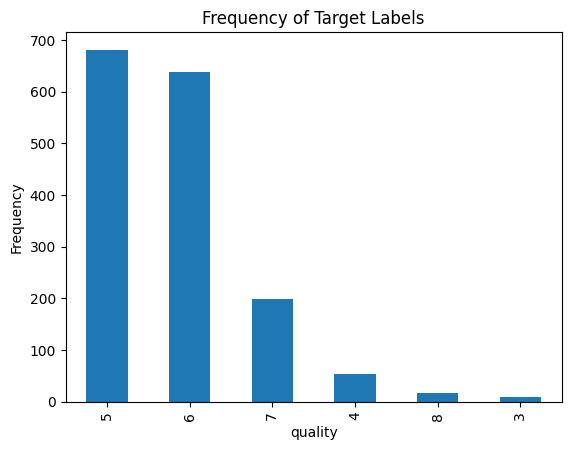

In [87]:
target = 'quality'
freques = wines[target].value_counts()
freques.plot(kind='bar')
plt.title('Frequency of Target Labels')
plt.xlabel('quality')
plt.ylabel('Frequency')
plt.show()

#### Split the data into the __predicting values__ `X` and the __target__ `y`
Drop also the columns which are not relevant for training a classifier, if any

The method "drop" of dataframes allows to drop either rows or columns
- the "axis" parameter chooses between dropping rows (axis=0) or columns (axis=1)

In [88]:
X = wines.drop(target, axis=1)
y = wines[target]

### Prepare the baseline: holdout method

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

print(f"There are {X_train.shape[0]} samples in the training set")
print(f"There are {X_test.shape[0]} samples in the test set")
print(f"Each sample has {X_train.shape[1]} feature")

There are 1119 samples in the training set
There are 480 samples in the test set
Each sample has 11 feature


- Initialize an estimator with the required model generator `tree.DecisionTreeClassifier(random_state = random_state)`
- Fit the estimator on the train data and target

In [90]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(
    random_state = random_state,
)
model.fit(X_train, y_train)
ytrain_dt = model.predict(X_train)

Let's see how it works on test data, and, comparing with the result on training data, see if you can suspect *overfitting*
- use the fitted estimator to predict using the test features
- compute the accuracy and store it on a variable for the final summary
- store the maximum depth of the tree, for later use 
    - `fitted_max_depth = estimator.tree_.max_depth`
- store the range of the parameter which will be used for tuning
    - `parameter_values = range(1,fitted_max_depth+1)`
- print the accuracy on the test set and the maximum depth of the tree

In [91]:
from sklearn.metrics import accuracy_score

In [92]:
ytest_dt = model.predict(X_test)
print(f"The accuracy on test set is: {accuracy_score(y_test, ytest_dt)*100:.2f}%")

fitted_max_depth = model.tree_.max_depth
print(f"The maximum depth of the tree fitted on X_train is {fitted_max_depth}")

parameter_values = range(1, fitted_max_depth+1)

The accuracy on test set is: 61.88%
The maximum depth of the tree fitted on X_train is 18


Prepare the decision tree parameters and the scores 

In [93]:
# Set the parameters to be explored during the rounds of cross-validation
tuned_param_dt = [{'max_depth': [*range(1,fitted_max_depth+1)]
                , 'criterion' : ['entropy', 'gini']
                , 'class_weight' : [None, 'balanced']}]

# Set the different scores that will be optimised
scores = ['accuracy'
        , 'precision_macro'
        , 'recall_macro'
        , 'f1_macro']

### Loop on scores
- iterate varying the score function
    - fit the estimator using the training data
        - the resulting model will be the best one according to the current score function
    - print the best estimator
    - print the best score
    - predict the target for the test set using the `.predict` method
    - print the `classification report`
    - display the confusion matrix with `ConfusionMatrixDisplay`

In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

# Tuning hyper-parameters for accuracy
{'class_weight': None, 'criterion': 'gini', 'max_depth': 12}
Best score: 61.21%
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.19      0.18      0.18        17
           5       0.72      0.74      0.73       202
           6       0.65      0.62      0.64       202
           7       0.37      0.47      0.41        49
           8       0.20      0.20      0.20         5

    accuracy                           0.63       480
   macro avg       0.36      0.37      0.36       480
weighted avg       0.63      0.63      0.63       480

# Tuning hyper-parameters for precision_macro
{'class_weight': None, 'criterion': 'gini', 'max_depth': 12}
Best score: 38.74%
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.19      0.18      0.18        17
           5       0.72      0.74      0.73      

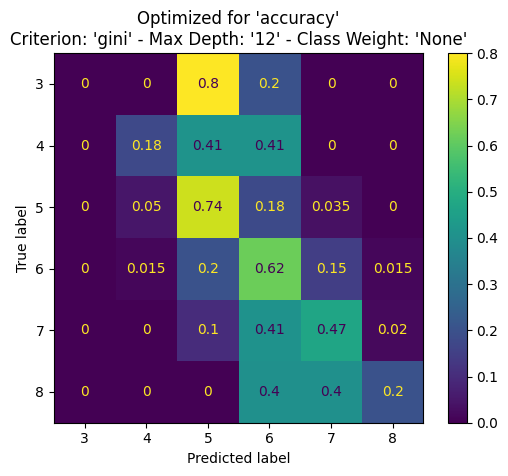

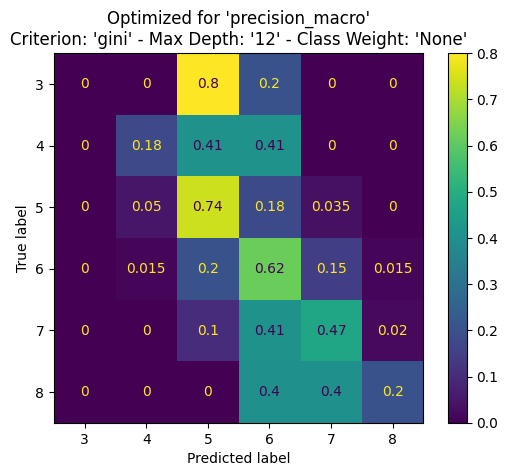

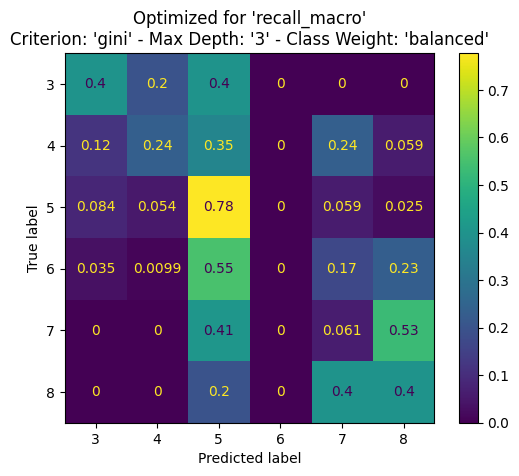

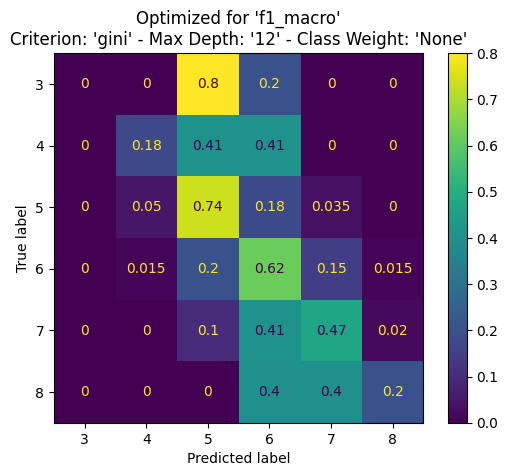

In [97]:
for score in scores: 
    model = DecisionTreeClassifier(random_state=random_state)
    model = GridSearchCV(model, tuned_param_dt, cv=5, scoring=score)
    model.fit(X_train, y_train)
    y_test_dt = model.predict(X_test)


    print("========================================")
    print(f"# Tuning hyper-parameters for {score}")
    print(model.best_params_)

    print(f"Best score: {model.best_score_*100:.2f}%")
    print(classification_report(y_test, y_test_dt))

    # confusion matrix
    cm = confusion_matrix(y_test, y_test_dt, normalize = 'true') # normalize set to 'all' is not relevant. Use 'true'
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
    disp.plot()
    plt.title(f"Optimized for '{score}'\nCriterion: '{model.best_params_["criterion"]}' - Max Depth: '{model.best_params_["max_depth"]}' - Class Weight: '{model.best_params_["class_weight"]}'")
plt.show()